In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import itertools 

import numpy as np

import pymc as pm

from modules.models.chapter_6 import estimate_latent_ability_membership, estimate_latent_ability_hier
from modules.models.chapter_6 import estimate_difficulty_ability

from modules.utils import validate_model, visualize_samples, visualize_matrices

In [3]:
PRPC_KWARGS={
    'samples': 1000
}
SAMPLING_KWARGS={
    'draws': 3000,
    'tune': 3000,
}
POPC_KWARGS={
}

# Estimate Latet Ability Group Membership

C:\Users\penthotal\Desktop\git_repositories\learning_bayes\books\bayesian_cognitive_modelling\modules\utils.py:33: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(**sampling_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [latent_group_membership_p, latent_group_2_ability, latent_group_1_ability]
>BinaryGibbsMetropolis: [latent_group_membership]


Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 134 seconds.
C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The number of effective samples is smaller than 25% for some parameters.
C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


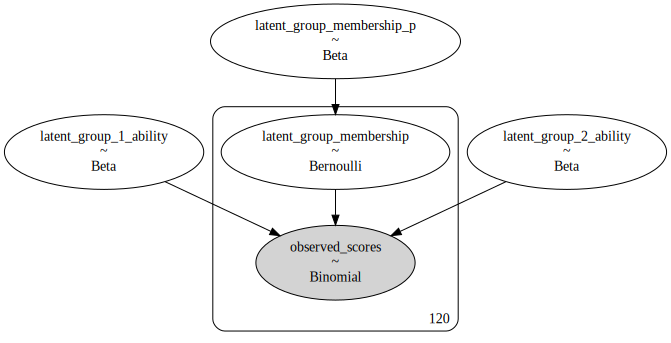

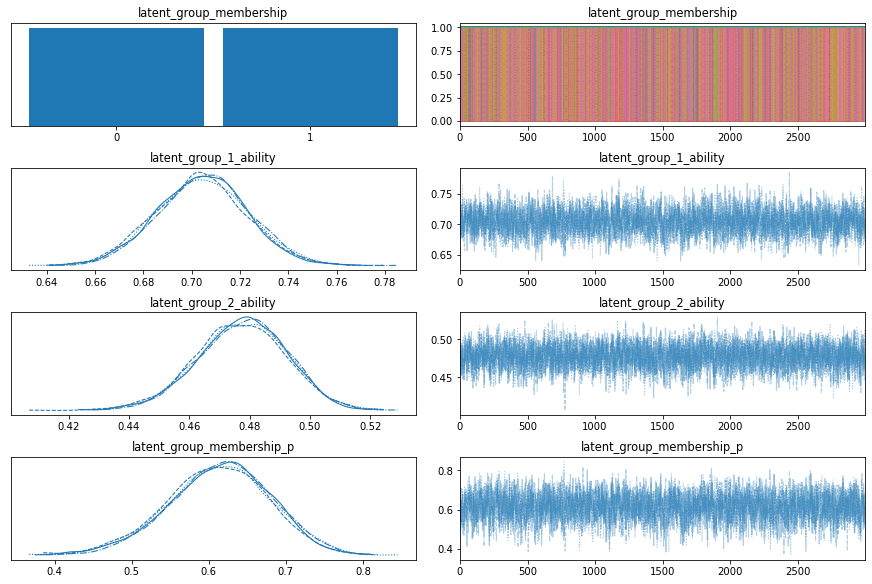

In [9]:
size_groups = 40
p_group_1 = 0.70
p_group_2 = 0.50
n_questions = 31

obs_scores = np.hstack(
    [
        np.random.binomial(n=n_questions, p=p_group_1, size=size_groups),
        np.random.binomial(n=n_questions, p=p_group_2, size=size_groups*2)
    ]
)

model = estimate_latent_ability_membership(
    obs_scores=obs_scores,
    number_questions=31,
    # if we don't specify informative priors
    # the model is not able to efficiently distinguish
    # between groups
    beta_1_kwargs={
        'alpha': 4,
        'beta': 2
    }, 
    beta_2_kwargs={
        'alpha': 2,
        'beta': 4
    },
    beta_bernoulli_kwargs={
        'alpha': 3,
        'beta': 2
    }
)

plate, prpc, trace, popc = validate_model(
    model,
    PRPC_KWARGS,
    SAMPLING_KWARGS,
    POPC_KWARGS
)
plate

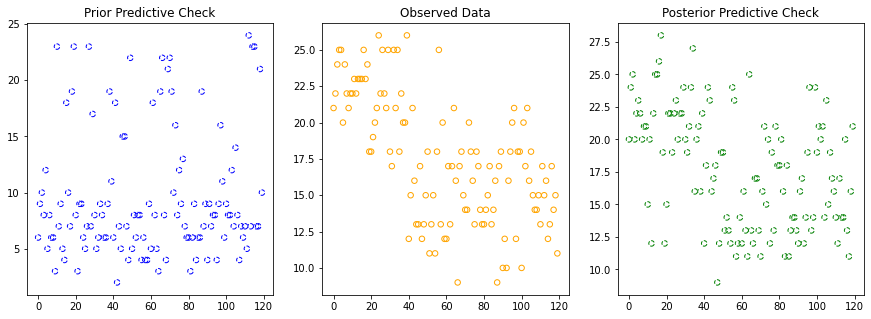

In [11]:
visualize_samples(
    observed=obs_scores, 
    prpc=prpc['observed_scores'][0, :], 
    popc=popc['observed_scores'][0, :],
    s=30
)

# Estimate Latet Ability (Hierarchically) and Group Membership

C:\Users\penthotal\Desktop\git_repositories\learning_bayes\books\bayesian_cognitive_modelling\modules\utils.py:33: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(**sampling_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [latent_group_membership_p, latent_group_2_ability, hyper_b_beta_2, hyper_a_beta_2, latent_group_1_ability, hyper_b_beta_1, hyper_a_beta_1]
>BinaryGibbsMetropolis: [latent_group_membership]


Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 291 seconds.
The number of effective samples is smaller than 10% for some parameters.
C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


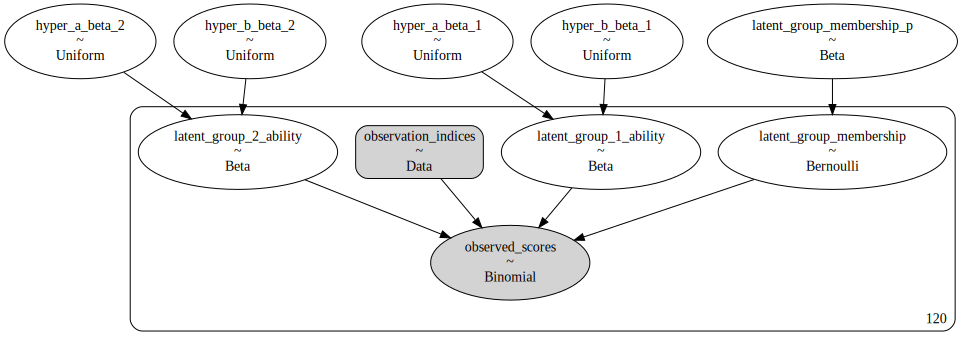

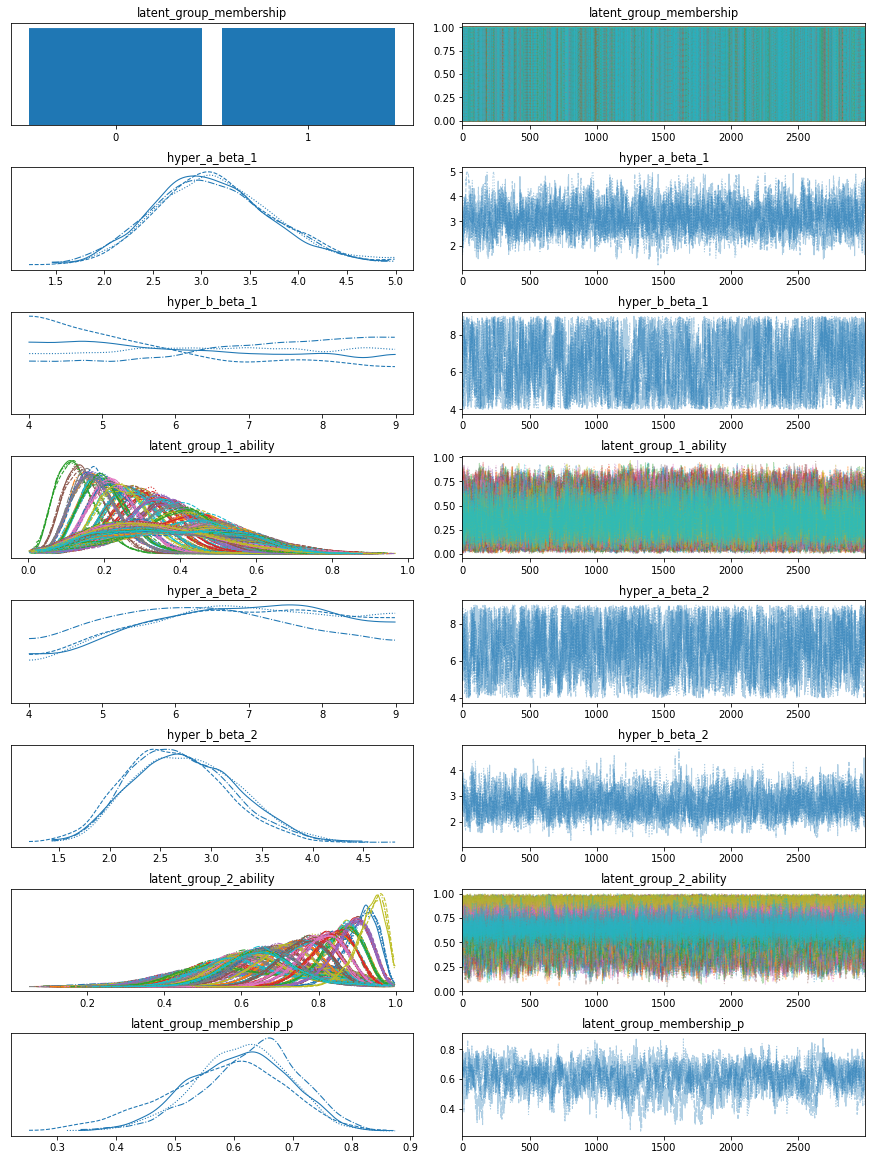

In [12]:
size_groups = 40
n_questions = 31

obs_scores = np.hstack(
    [
        np.random.binomial(n=n_questions, p=np.random.beta(a=3, b=7, size=size_groups)),
        np.random.binomial(n=n_questions, p=np.random.beta(a=7, b=3, size=size_groups*2))
    ]
)

model = estimate_latent_ability_hier(
    obs_scores=obs_scores,
    number_questions=31,
    a_beta_1_kwargs={
        'lower': 1,
        'upper': 5
    }, 
    b_beta_1_kwargs={
        'lower': 4,
        'upper': 9
    }, 
    a_beta_2_kwargs={
        'lower': 4,
        'upper': 9
    }, 
    b_beta_2_kwargs={
        'lower': 1,
        'upper': 5
    }, 
    beta_bernoulli_kwargs={
        'alpha': 5,
        'beta': 5
    }
)

plate, prpc, trace, popc = validate_model(
    model,
    PRPC_KWARGS,
    SAMPLING_KWARGS,
    POPC_KWARGS
)
plate

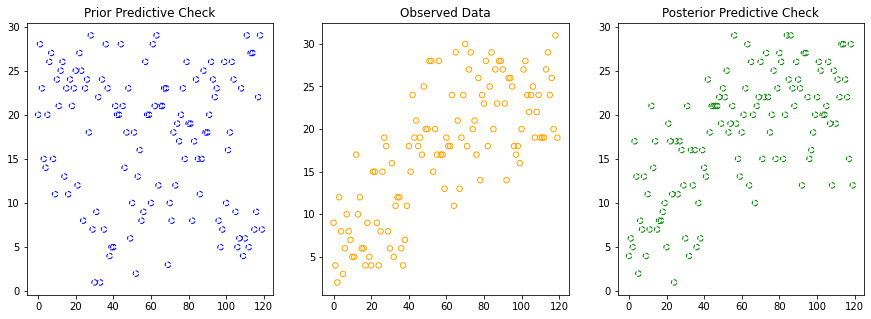

In [13]:
visualize_samples(
    observed=obs_scores, 
    prpc=prpc['observed_scores'][0, :], 
    popc=popc['observed_scores'][0, :],
    s=30
)

# Estimate Difficulty Ability

In [ ]:
abilities = np.linspace(0.1, 0.9, num=120)
difficulties = np.linspace(0.1, 0.9, num=31)

abilities_difficulties_idx = list(
    itertools.product(
        [ability for ability in range(len(abilities))], 
        [difficulty for difficulty in range(len(difficulties))], 
    )
)

ps = np.array(
    [
        abilities[ab_idx] * difficulties[diff_idx] for (ab_idx, diff_idx) in  abilities_difficulties_idx
    ]
)

answer_idx = np.array([ab_idx for (ab_idx, diff_idx) in abilities_difficulties_idx])
question_idx = np.array([diff_idx for (ab_idx, diff_idx) in abilities_difficulties_idx])
observed_answers = np.random.binomial(n=1, p=ps)

POPC_KWARGS_DIFF_AB={
    'samples': 1000,
    'var_names': ['p_answer_correct']
}

model = estimate_difficulty_ability(
    observed_answers=observed_answers, 
    question_idx=question_idx, 
    answer_idx=answer_idx,
    difficulty_beta_kwargs={
        'alpha': 5,
        'beta': 5
    }, 
    ability_beta_kwargs={
        'alpha': 5,
        'beta': 5
    }
)
plate, prpc, trace, popc = validate_model(
    model,
    PRPC_KWARGS,
    SAMPLING_KWARGS,
    POPC_KWARGS_DIFF_AB
)
plate

C:\Users\penthotal\Desktop\git_repositories\learning_bayes\books\bayesian_cognitive_modelling\modules\utils.py:33: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(**sampling_kwargs)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ability_answers, difficulty_questions]


In [ ]:
prior_matrix = np.empty(shape=(len(abilities), len(difficulties)))
observed_matrix = np.empty(shape=(len(abilities), len(difficulties)))
posterior_matrix = np.empty(shape=(len(abilities), len(difficulties)))

for idx, (ab_idx, diff_idx) in enumerate(abilities_difficulties_idx):
    
    prior_matrix[ab_idx][diff_idx] = np.median(prpc['p_answer_correct'], axis=0)[idx]
    observed_matrix[ab_idx][diff_idx] = observed_answers[idx]
    posterior_matrix[ab_idx][diff_idx] = np.median(popc['p_answer_correct'], axis=0)[idx]
    
visualize_matrices(
    observed=observed_matrix, 
    prpc=prior_matrix, 
    popc=posterior_matrix, 
    figsize=(15, 20)
)